#Sensor-Based Human Activity Classification Challenge

#Imports

In [1]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

# Data loading

In [3]:
file_path = '/content/pirvision_office_dataset1.csv'
data = pd.read_csv(file_path)

#Exploratory Data Analysis

In [4]:
data.shape

(7651, 59)

In [5]:
data.head()

,Date,Time,Label,Temperature_F,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,...,PIR_46,PIR_47,PIR_48,PIR_49,PIR_50,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55
0,2024-08-08,19:19:56,0,86,10269,10721,11156,11170,10931,10671,...,11178,11197,11161,11096,10957,10839,10735,10590,10411,10329
1,2024-08-08,19:20:12,1,86,10364,10907,11299,11238,10867,10535,...,11122,11145,11136,11108,11041,10824,10645,10493,10398,10357
2,2024-08-08,19:20:28,0,86,10329,10793,11197,11242,11052,10658,...,11168,11204,11162,11109,11007,10867,10700,10533,10427,10265
3,2024-08-08,19:20:44,0,86,10169,10425,10822,11133,11136,10834,...,11116,11273,11186,10984,10910,10807,10714,10651,10562,10463
4,2024-08-08,19:21:00,0,86,10320,10667,11104,11234,11129,10814,...,11006,11257,11370,11173,10924,10816,10754,10588,10428,10407


In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7651 entries, 0 to 7650
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           7651 non-null   object
 1   Time           7651 non-null   object
 2   Label          7651 non-null   int64 
 3   Temperature_F  7651 non-null   int64 
 4   PIR_1          7651 non-null   int64 
 5   PIR_2          7651 non-null   int64 
 6   PIR_3          7651 non-null   int64 
 7   PIR_4          7651 non-null   int64 
 8   PIR_5          7651 non-null   int64 
 9   PIR_6          7651 non-null   int64 
 10  PIR_7          7651 non-null   int64 
 11  PIR_8          7651 non-null   int64 
 12  PIR_9          7651 non-null   int64 
 13  PIR_10         7651 non-null   int64 
 14  PIR_11         7651 non-null   int64 
 15  PIR_12         7651 non-null   int64 
 16  PIR_13         7651 non-null   int64 
 17  PIR_14         7651 non-null   int64 
 18  PIR_15         7651 non-null

**Missing Values Check**

In [7]:
print("\nMissing Values:\n")
print(data.isnull().sum())


Missing Values:

Date             0
Time             0
Label            0
Temperature_F    0
PIR_1            0
PIR_2            0
PIR_3            0
PIR_4            0
PIR_5            0
PIR_6            0
PIR_7            0
PIR_8            0
PIR_9            0
PIR_10           0
PIR_11           0
PIR_12           0
PIR_13           0
PIR_14           0
PIR_15           0
PIR_16           0
PIR_17           0
PIR_18           0
PIR_19           0
PIR_20           0
PIR_21           0
PIR_22           0
PIR_23           0
PIR_24           0
PIR_25           0
PIR_26           0
PIR_27           0
PIR_28           0
PIR_29           0
PIR_30           0
PIR_31           0
PIR_32           0
PIR_33           0
PIR_34           0
PIR_35           0
PIR_36           0
PIR_37           0
PIR_38           0
PIR_39           0
PIR_40           0
PIR_41           0
PIR_42           0
PIR_43           0
PIR_44           0
PIR_45           0
PIR_46           0
PIR_47           0
PIR_48       

**Count of Data Corresponding to Each Label**


Count of Data Corresponding to Each Label in 'Label':

Label
0    6247
1     833
3     571
Name: count, dtype: int64


<ipython-input-8-77b17fc69740>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=data, palette='coolwarm', legend=False)


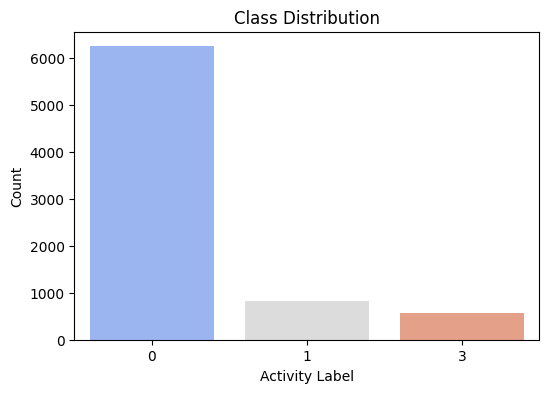

In [8]:
label_counts = data['Label'].value_counts()
print(f"\nCount of Data Corresponding to Each Label in '{'Label'}':\n")
print(label_counts)

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=data, palette='coolwarm', legend=False)
plt.title('Class Distribution')
plt.xlabel('Activity Label')
plt.ylabel('Count')
plt.show()

#Preprocessing

In [9]:
data.describe(include='all')

,Date,Time,Label,Temperature_F,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,...,PIR_46,PIR_47,PIR_48,PIR_49,PIR_50,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55
count,7651,7651,7651.000000,7651.000000,7.651000e+03,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,...,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000
unique,3,6424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2024-09-08,04:32:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,5532,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.332767,80.383871,2.501256e+05,11013.891648,11517.838452,11578.490786,11269.104169,10795.036989,...,11460.947458,11559.512874,11541.448438,11439.599529,11283.987061,11103.084564,10919.279441,10743.028624,10585.803294,10449.395373
std,NaN,NaN,0.818477,22.861417,4.292998e+06,591.799276,656.683841,663.111916,605.936126,537.247861,...,599.157249,627.996166,619.196749,598.563183,571.520024,546.310552,518.341483,487.208570,464.748286,450.231316
min,NaN,NaN,0.000000,0.000000,2.613000e+03,2615.000000,2614.000000,2611.000000,2612.000000,2613.000000,...,2606.000000,2606.000000,2606.000000,2605.000000,2605.000000,2609.000000,2605.000000,2604.000000,2603.000000,2602.000000
25%,NaN,NaN,0.000000,86.000000,1.033300e+04,10787.500000,11272.500000,11338.000000,11051.000000,10629.000000,...,11222.000000,11313.000000,11301.000000,11211.000000,11083.000000,10935.500000,10794.000000,10650.000000,10513.000000,10388.000000
50%,NaN,NaN,0.000000,86.000000,1.043100e+04,11002.000000,11557.000000,11629.000000,11301.000000,10790.000000,...,11488.000000,11583.000000,11566.000000,11471.000000,11319.000000,11137.000000,10948.000000,10760.000000,10597.000000,10454.000000
75%,NaN,NaN,0.000000,88.000000,1.056050e+04,11267.000000,11885.000000,11957.000000,11550.000000,10982.000000,...,11837.000000,11961.000000,11928.000000,11781.000000,11571.000000,11334.000000,11097.000000,10876.000000,10683.000000,10524.000000


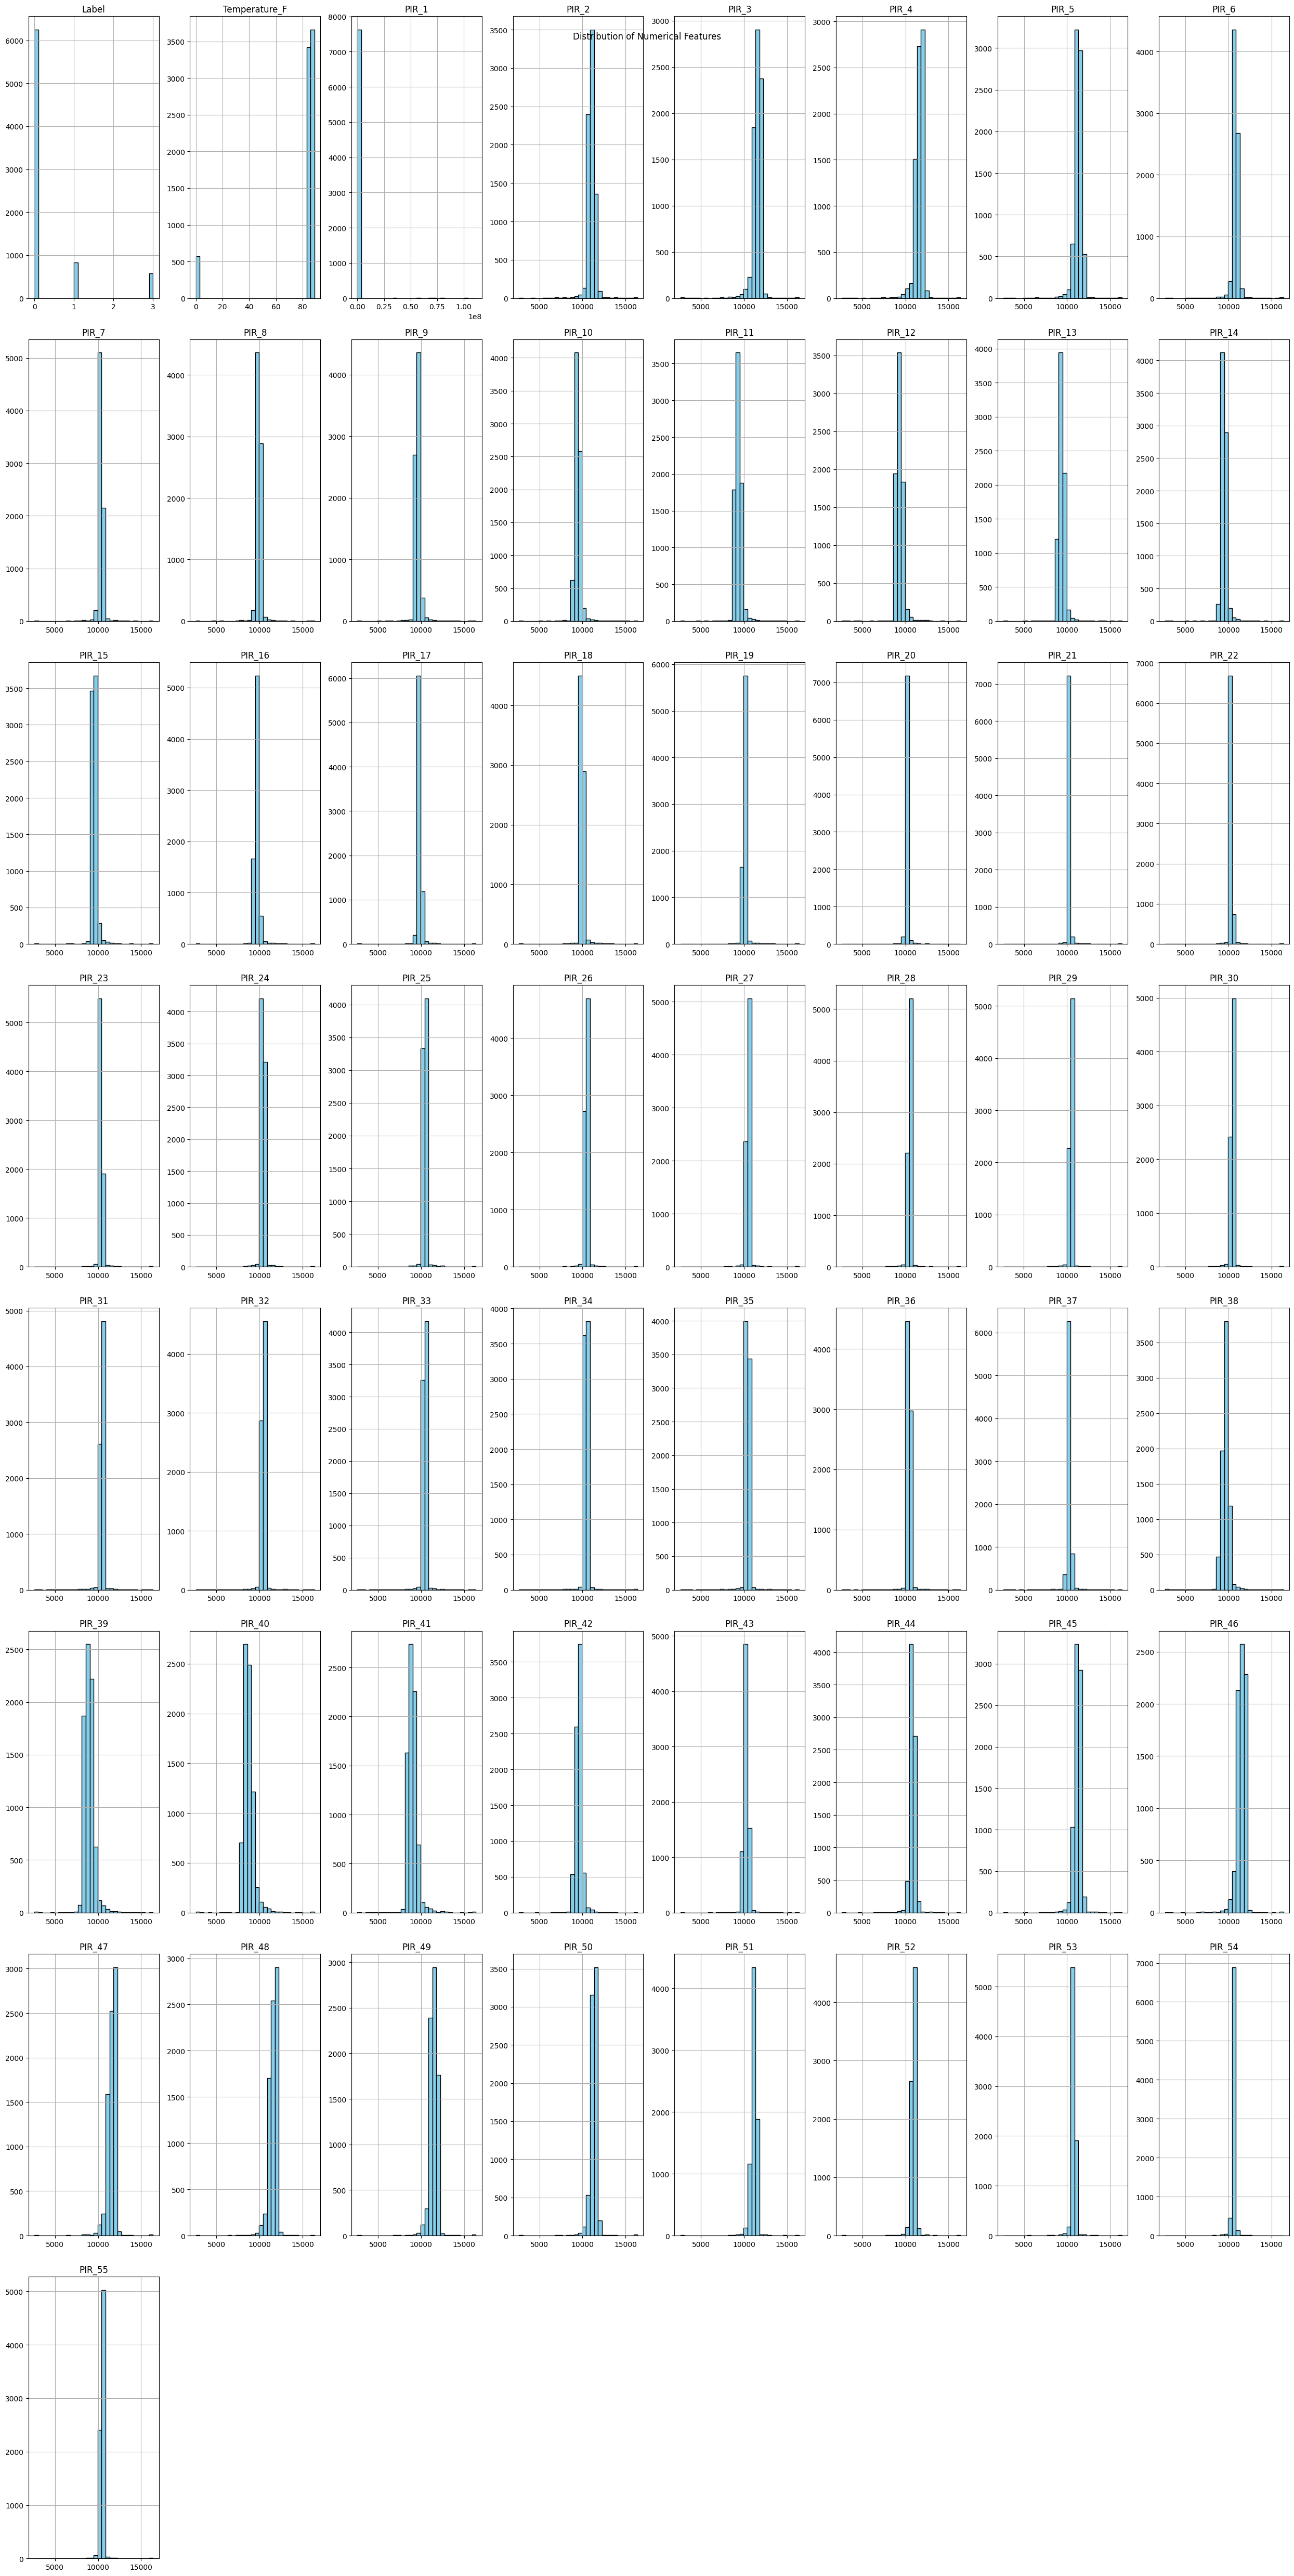

In [10]:
# Plot histograms for numerical columns
data.hist(figsize=(25, 50), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

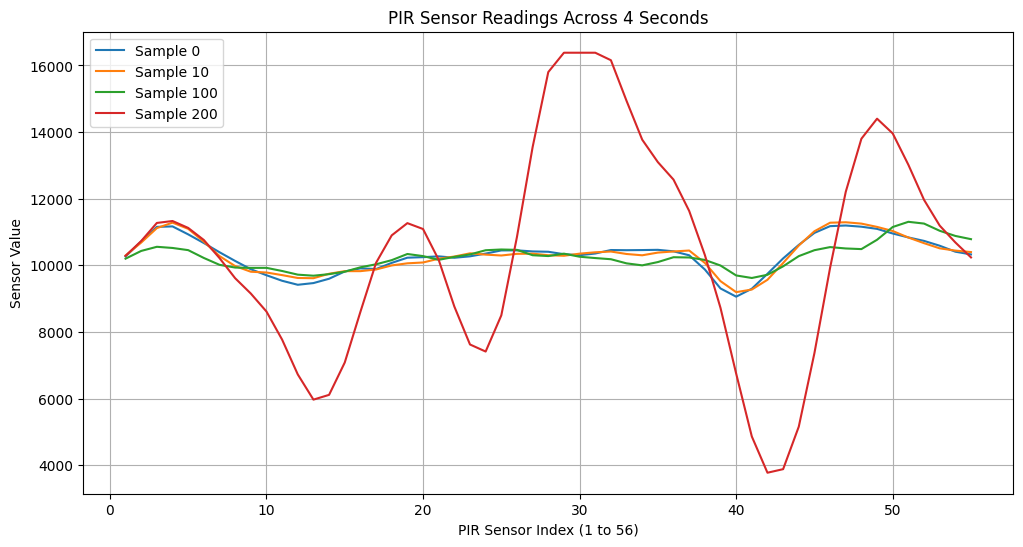

In [11]:
import matplotlib.pyplot as plt

# Sample a few rows
sample_indices = [0, 10, 100, 200]  # You can change or randomize
pir_columns = [f'PIR_{i}' for i in range(1, 56)]
X_sample = data.loc[sample_indices, pir_columns].values

# Plot each sample
plt.figure(figsize=(12, 6))
for i, sample in enumerate(X_sample):
    plt.plot(range(1, 56), sample, label=f'Sample {sample_indices[i]}')

plt.xlabel('PIR Sensor Index (1 to 56)')
plt.ylabel('Sensor Value')
plt.title('PIR Sensor Readings Across 4 Seconds')
plt.legend()
plt.grid(True)
plt.show()

**Date column Observation**


Unique Values in 'Date' and Their Counts:

Date
2024-08-08    1086
2024-09-08    5532
2024-10-08    1033
Name: count, dtype: int64


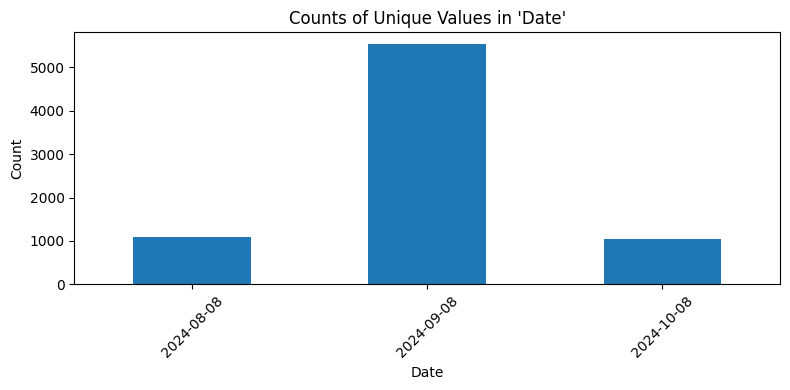

In [12]:
column_name = 'Date'

if column_name in data.columns:
    # Get unique values and their counts
    unique_values_count = data[column_name].value_counts().sort_index()
    print(f"\nUnique Values in '{column_name}' and Their Counts:\n")
    print(unique_values_count)

    plt.figure(figsize=(8, 4))
    unique_values_count.plot(kind='bar')
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.title(f"Counts of Unique Values in '{column_name}'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [13]:
# Count unique Dates values for each label
unique_dates_per_label = data.groupby('Label')['Date'].nunique()
print(unique_dates_per_label)

Label
0    3
1    2
3    2
Name: Date, dtype: int64


**Temperature Distribution**

In [14]:
column_name = 'Temperature_F'

if column_name in data.columns:
    # Get unique values and their counts
    unique_values_count = data[column_name].value_counts().sort_index()
    print(f"\nUnique Values in '{column_name}' and Their Counts:\n")
    print(unique_values_count)


Unique Values in 'Temperature_F' and Their Counts:

Temperature_F
0      571
85     867
86    2553
87    1253
88    1470
89     937
Name: count, dtype: int64


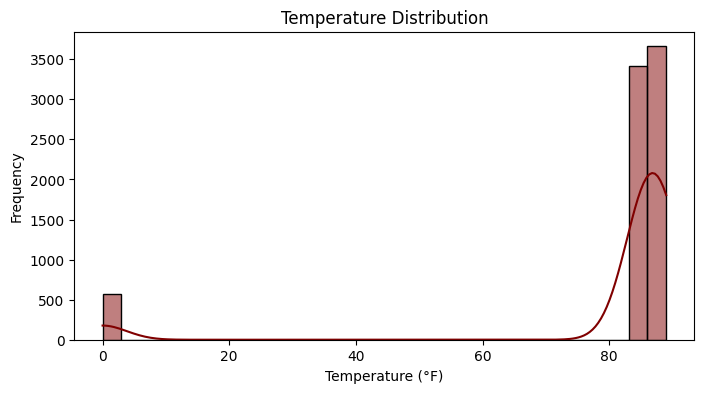

In [15]:
plt.figure(figsize=(8, 4))
sns.histplot(data['Temperature_F'], bins=30, kde=True, color='maroon')
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Count unique Temperature_F values for each label
unique_temps_per_label = data.groupby('Label')['Temperature_F'].nunique()
print(unique_temps_per_label)

Label
0    5
1    3
3    1
Name: Temperature_F, dtype: int64


In [17]:
# Check if all rows where Temperature_F is 0 has label 3 only
#(same label for all rows with Temperature_F=0)
temp_zero_labels = data[data['Temperature_F'] == 0]['Label']
all_same = temp_zero_labels.nunique() == 1

print("All labels are the same for Temperature_F == 0:", all_same)

All labels are the same for Temperature_F == 0: True


**PIR_1 column analysis**

In [16]:
# Group by 'Label' and calculate mean, min, and max of 'DIR_1'
dir1_stats = data.groupby('Label')['PIR_1'].agg(['mean', 'min', 'max'])

print(dir1_stats)

               mean   min        max
Label                               
0      1.047232e+04  3220      14842
1      1.037281e+04  9663      11673
3      3.221804e+06  2613  111602625


In [17]:
#PIR_1 with higher value than 20000
print("Total values in PIR_1 > 20000:", (data["PIR_1"] > 20000).sum())

Total values in PIR_1 > 20000: 29


#Feature Engineering

In [18]:
pir_columns = [f'PIR_{i}' for i in range(1, 56)] + ['Temperature_F']
mask_temp0 = data['Temperature_F'] == 0

# The rows with Temperature = 0 will always be classified as label 3
X_always_label3 = data.loc[mask_temp0, pir_columns].values
y_always_label3 = data.loc[mask_temp0, 'Label'].values

# Remaining rows are used for training
X_remaining = data.loc[~mask_temp0, pir_columns].values
y_remaining = data.loc[~mask_temp0, 'Label'].values

X_raw = X_remaining
y = y_remaining

# Use SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_raw_resampled, y_resampled_raw = smote.fit_resample(X_raw, y)

# Standardize features for neural network training
scaler_raw = StandardScaler()
X_scaled_raw = scaler_raw.fit_transform(X_raw_resampled)
joblib.dump(scaler_raw, 'scaler_raw.pkl')

X_tensor_raw = torch.tensor(X_scaled_raw, dtype=torch.float32)
y_tensor_raw = torch.tensor(y_resampled_raw, dtype=torch.long)

#Neural Network Model

In [ ]:
class PIRGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_classes=4):
        super(PIRGRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension (batch_size, seq_len=1, input_size)
        _, hn = self.gru(x)
        x = self.dropout(hn[-1])
        return self.fc(x)

In [19]:
class PIRLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_classes=2):
        super(PIRLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension (batch, seq_len=1, features)
        _, (hn, _) = self.lstm(x)   # Use final hidden state from LSTM
        x = self.dropout(hn[-1])
        return self.fc(x)   # Pass through final linear layer to get class scores

#Training & Validation

In [20]:
# Setup 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

#Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor_raw, y_tensor_raw)):
    X_train, X_val = X_tensor_raw[train_idx], X_tensor_raw[val_idx]
    y_train, y_val = y_tensor_raw[train_idx], y_tensor_raw[val_idx]

    # Prepare data loaders for training and validation
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

    model = PIRLSTM(input_size=X_tensor_raw.shape[1])
    #model = PIRMLP(input_size=X_tensor_raw.shape[1])
    #model = PIRGRU(input_size=X_tensor_raw.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Track metrics and best model per fold
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'macro_f1': 0.0, 'report': '', 'conf_matrix': None}
    best_val_acc = 0

    # Training loop for each epoch
    for epoch in range(20):
        model.train()
        total_train, correct_train, train_loss = 0, 0, 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            # Update training metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == y_batch).sum().item()
            total_train += y_batch.size(0)

        # Validation loop
        train_acc = correct_train / total_train
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)

        model.eval()
        total_val, correct_val, val_loss = 0, 0, 0.0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)

                # Store predictions and labels for metrics
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(y_batch.cpu().numpy())
                correct_val += (preds == y_batch).sum().item()
                total_val += y_batch.size(0)

        val_acc = correct_val / total_val
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)

        # Save model with highest validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'model_fold{fold+1}.pt')

    history['macro_f1'] = f1_score(all_targets, all_preds, average='macro')
    history['report'] = classification_report(all_targets, all_preds, digits=4)
    history['conf_matrix'] = confusion_matrix(all_targets, all_preds)

    fold_metrics.append(history)

# Visualization & Plots



        ----------------------------------------------FOLD1----------------------------------------------


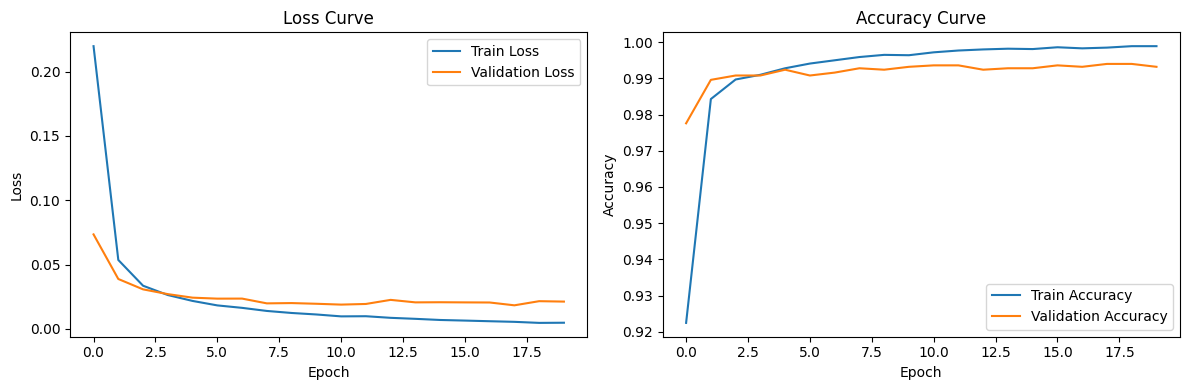



Macro F1 Score: 0.9932


Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9872    0.9932      1250
           1     0.9873    0.9992    0.9932      1249

    accuracy                         0.9932      2499
   macro avg     0.9933    0.9932    0.9932      2499
weighted avg     0.9933    0.9932    0.9932      2499



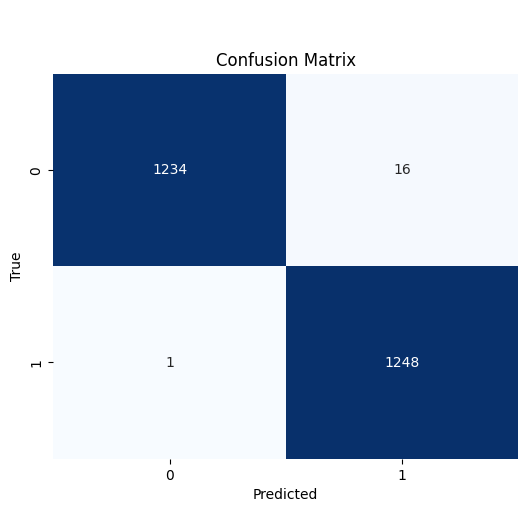



        ----------------------------------------------FOLD2----------------------------------------------


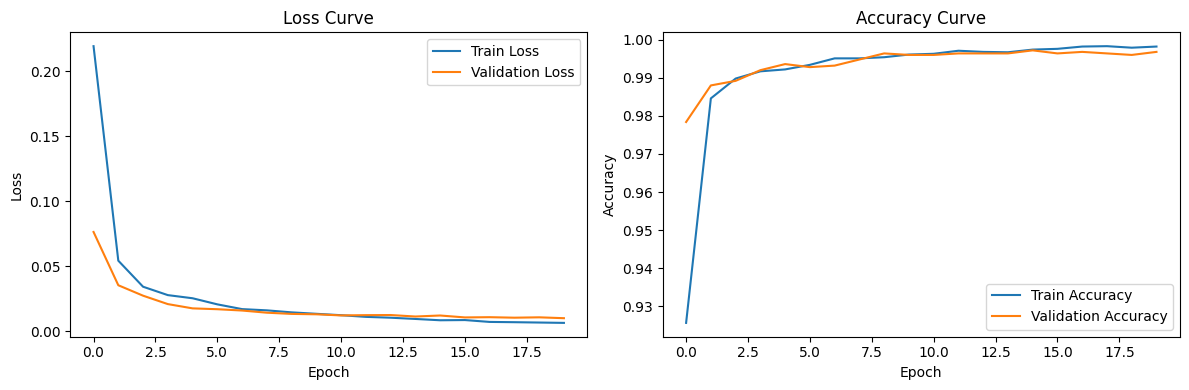



Macro F1 Score: 0.9968


Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9944    0.9968      1250
           1     0.9944    0.9992    0.9968      1249

    accuracy                         0.9968      2499
   macro avg     0.9968    0.9968    0.9968      2499
weighted avg     0.9968    0.9968    0.9968      2499



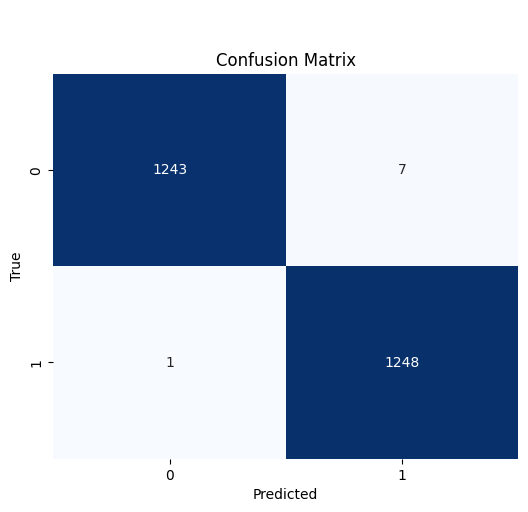



        ----------------------------------------------FOLD3----------------------------------------------


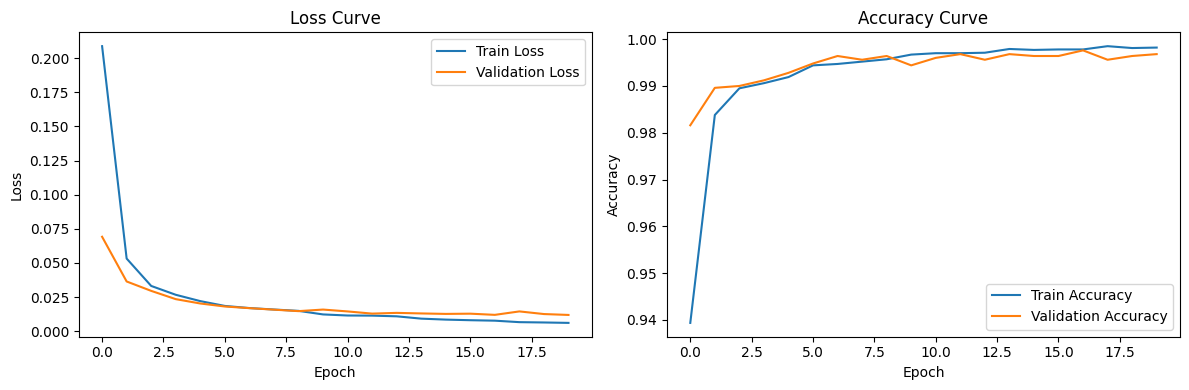



Macro F1 Score: 0.9968


Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9944    0.9968      1249
           1     0.9944    0.9992    0.9968      1250

    accuracy                         0.9968      2499
   macro avg     0.9968    0.9968    0.9968      2499
weighted avg     0.9968    0.9968    0.9968      2499



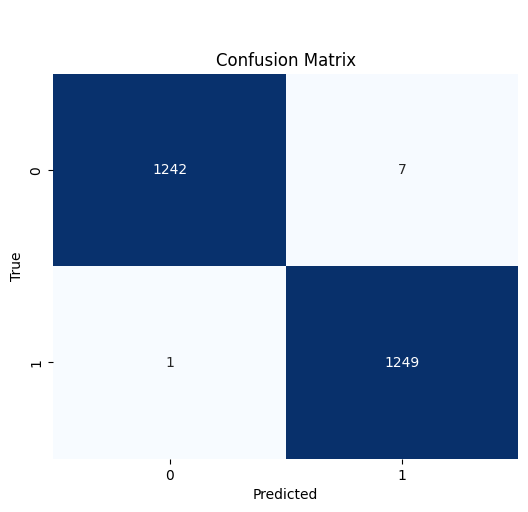



        ----------------------------------------------FOLD4----------------------------------------------


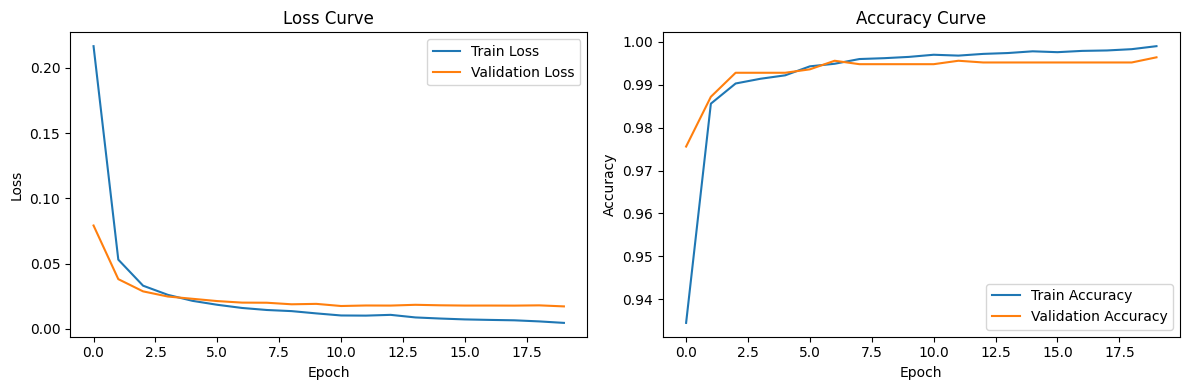



Macro F1 Score: 0.9964


Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9936    0.9964      1249
           1     0.9936    0.9992    0.9964      1250

    accuracy                         0.9964      2499
   macro avg     0.9964    0.9964    0.9964      2499
weighted avg     0.9964    0.9964    0.9964      2499



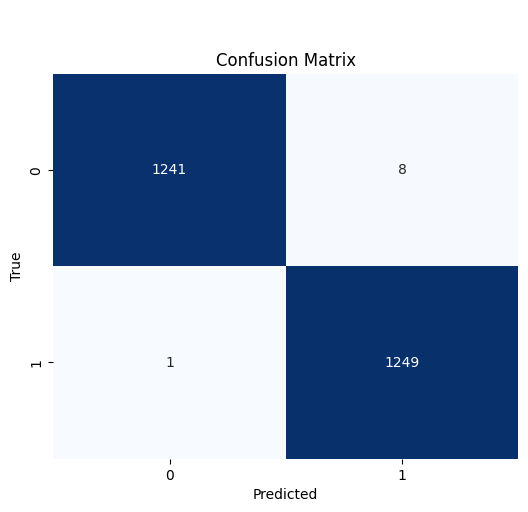



        ----------------------------------------------FOLD5----------------------------------------------


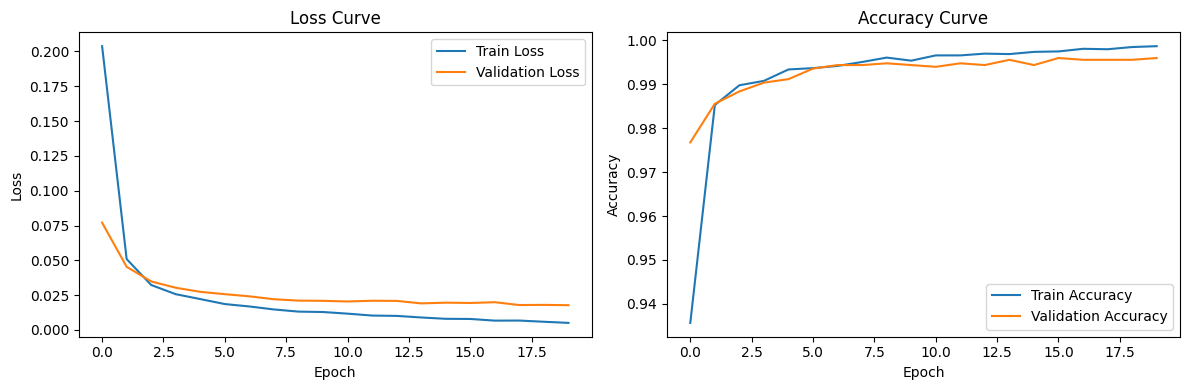



Macro F1 Score: 0.9960


Classification Report:
              precision    recall  f1-score   support

           0     0.9968    0.9952    0.9960      1249
           1     0.9952    0.9968    0.9960      1249

    accuracy                         0.9960      2498
   macro avg     0.9960    0.9960    0.9960      2498
weighted avg     0.9960    0.9960    0.9960      2498



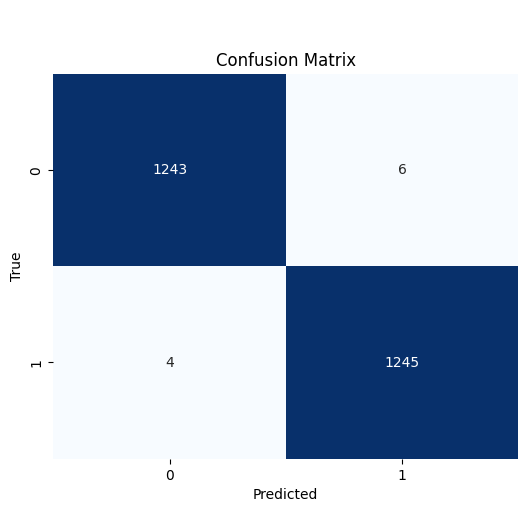

In [21]:
for i, metrics in enumerate(fold_metrics):
  #Training vs. Validation Loss curves
    print(f"\n\n        ----------------------------------------------FOLD{i+1}----------------------------------------------")
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f'Loss Curve'); plt.legend()

  #Training vs. Validation Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve'); plt.legend()
    plt.tight_layout(); plt.show()

  #1. Macro F1-Score
  #2. Class-wise Precision, Recall, F1
  #3.  Confusion Matrix

    print(f"\n\nMacro F1 Score: {metrics['macro_f1']:.4f}")
    print(f"\n\nClassification Report:\n{metrics['report']}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.title(f'\n\nConfusion Matrix')
    plt.show()


# Final Results

In [22]:
mean_train_acc = np.mean([max(m['train_acc']) for m in fold_metrics])
mean_val_acc = np.mean([max(m['val_acc']) for m in fold_metrics])
mean_train_loss = np.mean([min(m['train_loss']) for m in fold_metrics])
mean_val_loss = np.mean([min(m['val_loss']) for m in fold_metrics])
all_macro_f1s = [fold['macro_f1'] for fold in fold_metrics]

print(f"\nAverage Training Accuracy across folds: {mean_train_acc:.4f}")
print(f"Average Validation Accuracy across folds: {mean_val_acc:.4f}")
print(f"Average Training Loss across folds: {mean_train_loss:.4f}")
print(f"Average Validation Loss across folds: {mean_val_loss:.4f}")
print(f"Average Macro F1 Score   : {np.mean(all_macro_f1s):.4f}")


Average Training Accuracy across folds: 0.9987
Average Validation Accuracy across folds: 0.9962
Average Training Loss across folds: 0.0054
Average Validation Loss across folds: 0.0151
Average Macro F1 Score   : 0.9958


In [23]:
print(f"Std Dev of Macro F1       : {np.std(all_macro_f1s):.4f}")
print(f"Std Dev of Val Accuracy   : {np.std(mean_val_acc):.4f}")


Std Dev of Macro F1       : 0.0014
Std Dev of Val Accuracy   : 0.0000


# Evaluation Function

In [24]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def evaluate_model(datafile_location, checkpoint):
    # Load data
    data = pd.read_csv(datafile_location)

    # Preprocess
    pir_columns = [f'PIR_{i}' for i in range(1, 56)] + ['Temperature_F']
    mask_temp0 = data['Temperature_F'] == 0

    X_eval = data.loc[~mask_temp0, pir_columns].values
    y_eval = data.loc[~mask_temp0, 'Label'].values

    # Load the saved scaler
    from joblib import load
    scaler = load('scaler_raw.pkl')
    X_scaled = scaler.transform(X_eval)

    # Convert to tensor
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    # Load model and weights
    model = PIRLSTM(input_size=X_tensor.shape[1])
    model.load_state_dict(torch.load(checkpoint))
    model.eval()

    # Predict
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs, 1)
        predictions = predicted.numpy()

    accuracy = accuracy_score(y_eval, predictions)
    return accuracy


In [26]:
acc = evaluate_model('pirvision_office_dataset2.csv', 'model_fold1.pt')
print(acc)

0.9968926553672316


#Prediction

In [72]:
import numpy as np
import torch

# New PIR value to predict
new_pir_input = np.array([[10364, 10907, 11299, 11238, 10867, 10535, 10173,  9950,  9856,
        9795,  9714,  9702,  9792,  9789,  9915,  9900,  9944,  9964,
        9971, 10059, 10161, 10234, 10285, 10309, 10384, 10464, 10450,
       10427, 10366, 10361, 10452, 10502, 10444, 10337, 10250, 10313,
       10211,  9718,  9236,  9193,  9609, 10022, 10431, 10798, 11055,
       11122, 11145, 11136, 11108, 11041, 10824, 10645, 10493, 10398,
       10357]])  # shape: (1, 55)

temperature_value = 73.5

# Combine PIR + Temperature into a single input (shape: 1 x 56)
new_input_full = np.hstack((new_pir_input, [[temperature_value]]))  # shape: (1, 56)

# Scale input using the same scaler used during training
new_input_scaled = scaler_raw.transform(new_input_full)

# Convert to torch tensor
new_input_tensor = torch.tensor(new_input_scaled, dtype=torch.float32)

# Set model to evaluation mode
model.eval()

# Predict
with torch.no_grad():
    output = model(new_input_tensor)
    _, predicted_class = torch.max(output, 1)

# Map prediction to human-readable label
label_map = {
    0: "Vacancy",
    1: "Stationary human presence",
    3: "Other activity/motion"
}

predicted_label = label_map.get(predicted_class.item(), "Unknown class")

# Print result
print(f"\nPredicted Class: {predicted_class.item()} → {predicted_label}")



Predicted Class: 1 → Stationary human presence
